In [1]:
import os
import math
import pickle
import pandas as pd
import numpy as np
import ast
from scipy.spatial.distance import pdist
import pingouin as pg
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns


ParticipantID	Timestamp	TaskNumber	Condition	Task	Style	Question	ViewingTimeSeconds	CorrectAnswer	UserAnswer	IsCorrect	TimeToAnswerSeconds	StickerRandomSeed	Section	ScreenWidth	DisplayDistance	MaxViewAngle	HeadPosXRaw	LeftHeadPosXRaw	RightHeadPosXRaw	LeftAccumHeadPosXRaw	RightAccumHeadPosXRaw	HeadPosXNorm	HeadAngleRaw	HeadAngleNorm	HeadPosZ	OptiTrackHeadX	OptiTrackHeadY	OptiTrackHeadZ	OptiTrackDisplayX	OptiTrackDisplayY	OptiTrackDisplayZ


In [67]:
cleanDF = pd.read_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput', 'test_all_data_chx_withdiff_Cleaned_chx.csv'))

### 头部运动路径分析

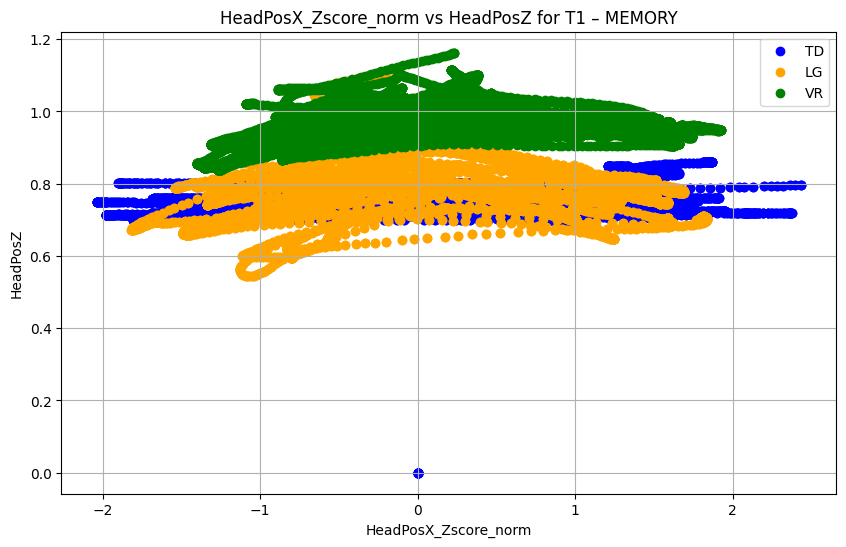

In [63]:
column = 'HeadPosX_Zscore_norm'
# 描述他的分布
participant_data[column].describe()
# 画散点图
plt.figure(figsize=(10, 6))
plt.scatter(participant_data['MemoryRelativeTime'][:1000], participant_data[column][:1000], alpha=0.5)
plt.xlabel('MemoryRelativeTime')
plt.ylabel(column)
plt.title(f'Scatter plot of {column} for Participant {participant_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
# 分析
df = cleanDF.copy()

# 剔除为0的行
df = df[df['HeadPosZ_diff'] != 0]
df = df[df['HeadPosXRaw_diff'] != 0]
df = df[df['MemoryRelativeTime_diff'] != 0]

# 重置索引
df.reset_index(drop=True, inplace=True)
# 按照Task,Style,Section分组
grouped = df.groupby(['ParticipantID', 'TaskNumber', 'Task',  'Section', 'Condition'])

In [69]:
len(list(grouped.groups.keys()))

3854

In [58]:
ParticipantID =  20
TaskNumber = 3
Task = 'T2'
Section = 'RECALL'
condition = 'VR'
# 按照grouped.groups.keys()提取MemoryRelativeTime,HeadPosXNorm,HeadPosZ的值，
grouped_data_xz = grouped.get_group((ParticipantID, TaskNumber, Task, Section, condition))

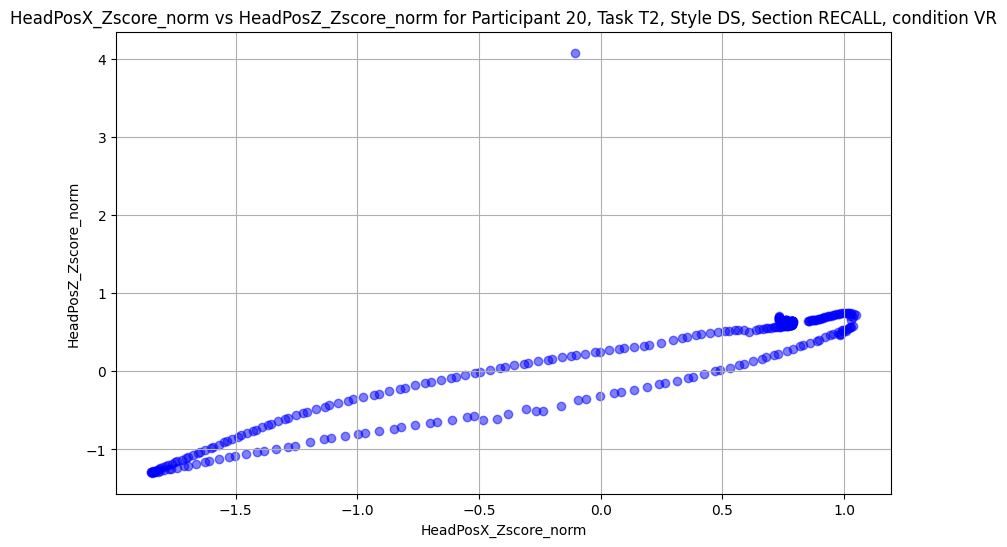

In [59]:
# 画grouped_data_xz的HeadPosX_Zscore_norm和HeadPosZ的散点图
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data_xz['HeadPosX_Zscore_norm'], grouped_data_xz['HeadPosZ_Zscore_norm'], color='blue', alpha=0.5)
plt.title(f'HeadPosX_Zscore_norm vs HeadPosZ_Zscore_norm for Participant {ParticipantID}, Task {Task}, Style DS, Section {Section}, condition {condition}')
plt.xlabel('HeadPosX_Zscore_norm')
plt.ylabel('HeadPosZ_Zscore_norm')
plt.grid()
plt.show()

In [60]:
grouped_data_xz.head(3)

,Unnamed: 0,ParticipantID,Timestamp,MemoryRelativeTime,MemoryRelativeTime_diff,TaskNumber,Condition,Task,Style,Question,...,HeadAngleRaw,HeadAngleRaw_diff,HeadAngleNorm,HeadAngleRaw_Zscore_norm,HeadPosZ,HeadPosZ_diff,HeadPosZ_Zscore_norm,OptiTrackHeadX,OptiTrackHeadY,OptiTrackHeadZ
1765431,1773030,20,1:51:44 PM,0.026240,-19.959494,3,VR,T2,ST,Where was this sticker located on the building?,...,-1.112939,-0.002817,-0.041998,-0.085961,1.190804,-0.000632,4.079715,0.563420,0.501484,0.104574
1765432,1773032,20,1:51:44 PM,0.052481,0.013120,3,VR,T2,ST,Where was this sticker located on the building?,...,-1.117851,-0.009669,-0.042183,0.732952,1.188558,-0.000977,0.707627,0.561374,0.501294,0.104449
1765433,1773033,20,1:51:44 PM,0.065601,0.013120,3,VR,T2,ST,Where was this sticker located on the building?,...,-1.118376,-0.000525,-0.042203,0.732820,1.187844,-0.000714,0.699448,0.561115,0.501132,0.104492


C:\Users\Chen_Hex\AppData\Local\Temp\ipykernel_3896\2451018284.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = df['MemoryRelativeTime'].diff().fillna(method='bfill')


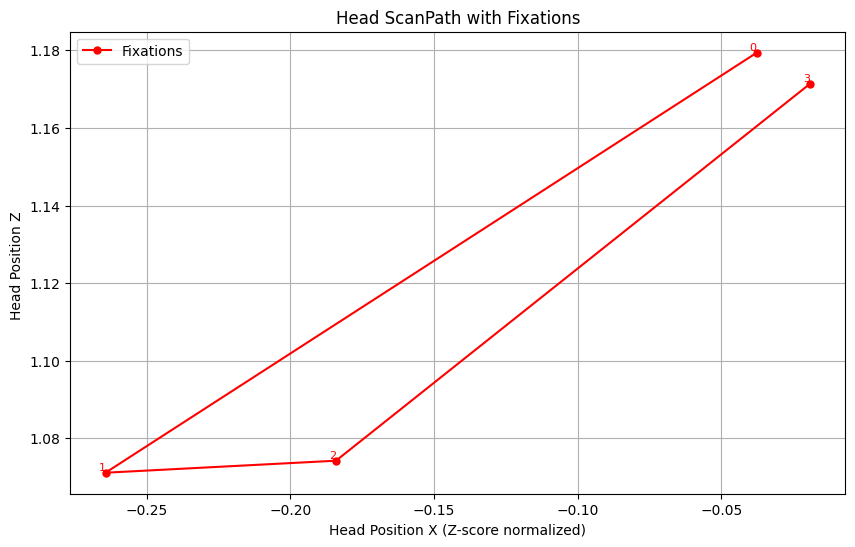

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 用户参数
VELOCITY_THRESHOLD = 0.4  # 判断固视和扫视的速度阈值
MIN_FIXATION_DURATION = 0.008  # 判断固视的最小持续时间（秒），注意资源分配对信息范畴化的影响80ms是普遍可以被接受的点
SMOOTH_WINDOW = 3  # 滑动平均窗口（帧数）

# 1. 读取原始数据
df = pd.DataFrame(grouped_data_xz)

# 3. 平滑坐标（移动平均）
df['x_smooth'] = df['HeadPosXRaw'].rolling(window=SMOOTH_WINDOW, center=True, min_periods=1).mean()
df['y_smooth'] = df['HeadPosZ'].rolling(window=SMOOTH_WINDOW, center=True, min_periods=1).mean()

# 4. 计算速度
dx = df['x_smooth'].diff() 
dy = df['y_smooth'].diff()
dt = df['MemoryRelativeTime'].diff().fillna(method='bfill')
speed = np.sqrt(dx**2 + dy**2) / dt 

# 5. 事件分类
df['event'] = np.where(speed <= VELOCITY_THRESHOLD, 'fixation', 'saccade')

# 6. 聚合连续固视样本为固视事件
fixations = []
current = None

for idx, row in df.iterrows():
    if row['event'] == 'fixation':
        if current is None:
            current = {'start': row['MemoryRelativeTime'], 'xs': [], 'ys': []}
        current['xs'].append(row['x_smooth'])
        current['ys'].append(row['y_smooth'])
    else:
        if current is not None:
            duration = row['MemoryRelativeTime'] - current['start']
            if duration >= MIN_FIXATION_DURATION:
                fixations.append({
                    'timestamp': current['start'],
                    'x': np.mean(current['xs']),
                    'y': np.mean(current['ys']),
                    'duration': duration
                })
            current = None

# 若最后为固视，也需检查
if current is not None:
    duration = df['MemoryRelativeTime'].iloc[-1] - current['start']
    if duration >= MIN_FIXATION_DURATION:
        fixations.append({
            'timestamp': current['start'],
            'x': np.mean(current['xs']),
            'y': np.mean(current['ys']),
            'duration': duration
        })

fix_df = pd.DataFrame(fixations)
# 画出固视点的顺序数字
# 7. 绘制扫描路径
plt.figure(figsize=(10, 6))
# plt.plot(df['HeadPosX_Zscore_norm'], df['HeadPosZ'], 'o-', alpha=0.5, label='Raw Data')
plt.plot(fix_df['x'], fix_df['y'], 'ro-', markersize=5, label='Fixations')
# 画出固视点的顺序数字
for i, row in fix_df.iterrows():
    plt.text(row['x'], row['y'], str(i), fontsize=8, ha='right', va='bottom', color='red')
plt.title('Head ScanPath with Fixations')
plt.xlabel('Head Position X (Z-score normalized)')
plt.ylabel('Head Position Z ')
plt.legend()
plt.grid()
plt.show()


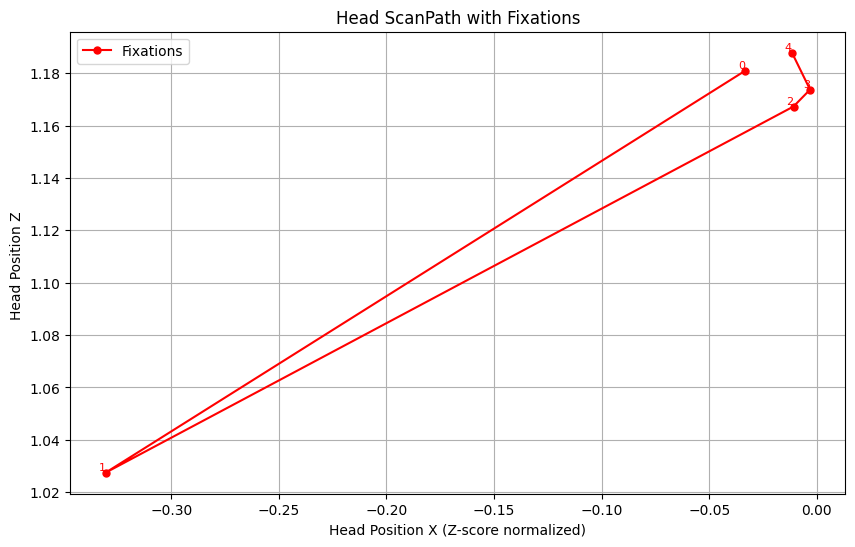

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 用户参数
VELOCITY_THRESHOLD = 0.3  # 判断固视和扫视的速度阈值
MIN_FIXATION_DURATION = 0.08  # 判断固视的最小持续时间（秒），注意资源分配对信息范畴化的影响80ms是普遍可以被接受的点
SMOOTH_WINDOW = 3  # 滑动平均窗口（帧数）

# 1. 读取原始数据
df = pd.DataFrame(grouped_data_xz)

# 3. 不平滑坐标，直接使用原始数据,去掉diff为0的行
df = df[(df['HeadPosXRaw'] != 0) & (df['HeadPosZ'] != 0)]
df['x_smooth'] = df['HeadPosXRaw']
df['y_smooth'] = df['HeadPosZ']

# 4. 计算速度
dx = df['HeadPosXRaw_diff']
dy = df['HeadPosZ_diff']
dt = df['MemoryRelativeTime_diff']
speed = np.sqrt(dx**2 + dy**2) / dt

# 5. 事件分类
df['event'] = np.where(speed <= VELOCITY_THRESHOLD, 'fixation', 'saccade')

# 6. 聚合连续固视样本为固视事件
fixations = []
current = None

for idx, row in df.iterrows():
    if row['event'] == 'fixation':
        if current is None:
            current = {'start': row['MemoryRelativeTime'], 'xs': [], 'ys': []}
        current['xs'].append(row['x_smooth'])
        current['ys'].append(row['y_smooth'])
    else:
        if current is not None:
            duration = row['MemoryRelativeTime'] - current['start']
            if duration >= MIN_FIXATION_DURATION:
                fixations.append({
                    'timestamp': current['start'],
                    'x': np.mean(current['xs']),
                    'y': np.mean(current['ys']),
                    'duration': duration
                })
            current = None

# 若最后为固视，也需检查
if current is not None:
    duration = df['MemoryRelativeTime'].iloc[-1] - current['start']
    if duration >= MIN_FIXATION_DURATION:
        fixations.append({
            'timestamp': current['start'],
            'x': np.mean(current['xs']),
            'y': np.mean(current['ys']),
            'duration': duration
        })

fix_df = pd.DataFrame(fixations)
# 画出固视点的顺序数字
# 7. 绘制扫描路径
plt.figure(figsize=(10, 6))
# plt.plot(df['HeadPosX_Zscore_norm'], df['HeadPosZ'], 'o-', alpha=0.5, label='Raw Data')
plt.plot(fix_df['x'], fix_df['y'], 'ro-', markersize=5, label='Fixations')
# 画出固视点的顺序数字
for i, row in fix_df.iterrows():
    plt.text(row['x'], row['y'], str(i), fontsize=8, ha='right', va='bottom', color='red')
plt.title('Head ScanPath with Fixations')
plt.xlabel('Head Position X (Z-score normalized)')
plt.ylabel('Head Position Z ')
plt.legend()
plt.grid()
plt.show()


In [44]:
df.columns

Index(['ParticipantID', 'Timestamp', 'MemoryRelativeTime',
       'MemoryRelativeTime_diff', 'TaskNumber', 'Condition', 'Task', 'Style',
       'Question', 'IsCorrect', 'TimeToAnswerSeconds', 'TimeForMemory',
       'Section', 'HeadPosXRaw', 'HeadPosXRaw_diff', 'HeadPosX_Zscore_norm',
       'LeftHeadPosXRaw', 'RightHeadPosXRaw', 'LeftAccumHeadPosXRaw',
       'RightAccumHeadPosXRaw', 'HeadPosXNorm', 'HeadAngleRaw',
       'HeadAngleRaw_diff', 'HeadAngleNorm', 'HeadAngleNorm_Zscore_norm',
       'HeadPosZ', 'HeadPosZ_diff', 'HeadPosZ_Zscore_norm', 'OptiTrackHeadX',
       'OptiTrackHeadY', 'OptiTrackHeadZ', 'HeadAngleRaw_Zscore_norm',
       'x_smooth', 'y_smooth', 'event'],
      dtype='object')

In [29]:
import numpy as np
import pandas as pd

# 1  I-DT算法（Dispersion Threshold Identification）
df = pd.DataFrame(grouped_data_xz)

# dt_thresh空间阈值，dur_thresh时间阈值
# 2. I-DT fixation detection
def detect_fixations(data, dt_thresh=0.1, dur_thresh=0.08):
    times = data['MemoryRelativeTime'].values
    xs = data['HeadPosXRaw'].values
    ys = data['HeadPosZ'].values
    fs = 1.0 / np.mean(np.diff(times))  # sampling frequency
    window_size = int(np.ceil(dur_thresh * fs))
    
    fixations = []
    start = 0
    while start + window_size <= len(times):
        end = start + window_size
        # Expand window while dispersion <= threshold
        while end < len(times):
            disp = (xs[start:end].max() - xs[start:end].min()) + \
                   (ys[start:end].max() - ys[start:end].min())
            if disp > dt_thresh:
                break
            end += 1
        
        # If initial window met dispersion threshold, record fixation
        if end - start >= window_size:
            fixations.append({
                'start_idx': start,
                'end_idx': end - 1,
                'start_time': times[start],
                'end_time': times[end - 1]
            })
            start = end  # move past this fixation
        else:
            start += 1  # slide window forward
    
    return pd.DataFrame(fixations)

# Run detection
fixations_df = detect_fixations(df, dt_thresh=0.15, dur_thresh=0.1)

In [30]:
times = df['MemoryRelativeTime'].values
fs = 1.0 / np.mean(np.diff(times))

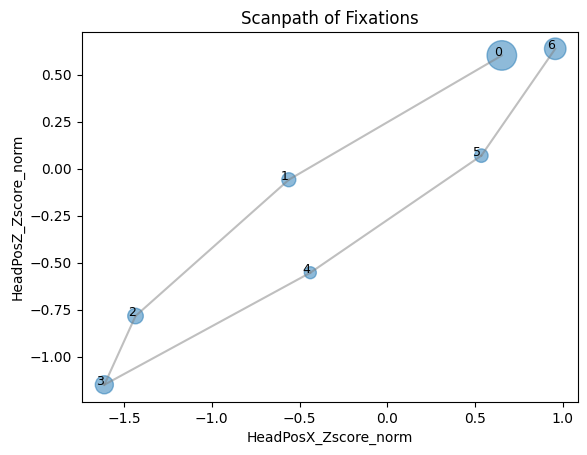

In [71]:
# Compute centroids of each fixation (casting indices to int)
# 根据注视时间绘制注视点的大小
centroids = []
for _, row in fixations_df.iterrows():
    start_idx = int(row['start_idx'])
    end_idx = int(row['end_idx'])
    segment = df.iloc[start_idx:end_idx + 1]
    fixation_duration = row['end_time'] - row['start_time']
    centroids.append([
        segment['HeadPosX_Zscore_norm'].mean(),
        segment['HeadPosZ_Zscore_norm'].mean()
    ])
centroids = np.array(centroids)

# Plot scanpath
plt.figure()
#设置点大小和注视时长的关系
sizes = (fixations_df['end_time'] - fixations_df['start_time']) * 300
# 按注视点的顺序画点并标上数字序号
# 按顺序连接
plt.scatter(centroids[:, 0], centroids[:, 1], s=sizes, alpha=0.5)
for i, (x, y) in enumerate(centroids):
    plt.text(x, y, str(i), fontsize=9, ha='right')


for i in range(len(centroids) - 1):
    plt.plot(centroids[i:i+2, 0], centroids[i:i+2, 1], color='gray', alpha=0.5)

plt.xlabel('HeadPosX_Zscore_norm')
plt.ylabel('HeadPosZ_Zscore_norm')
plt.title('Scanpath of Fixations')
plt.show()

In [32]:
detect_fixations(df, dt_thresh=0.15, dur_thresh=0.01)

,start_idx,end_idx,start_time,end_time
0,0,114,0.026240,1.535056
1,115,141,1.548176,1.889299
2,142,174,1.902419,2.322264
3,175,218,2.335384,2.899550
4,219,238,2.912670,3.161952
5,239,263,3.175072,3.489956
6,264,317,3.503076,4.303404


In [72]:
import numpy as np
from scipy.spatial import KDTree, distance_matrix
from matplotlib import pyplot as plt

# ========================
# 1. 生成测试数据
# ========================
# 连续点示例：沿正弦曲线分布
num_points = 200
x_cont = np.linspace(0, 4*np.pi, num_points)
y_cont = np.sin(x_cont) + np.random.normal(0, 0.1, num_points)  # 添加少量噪声
continuous_points = np.column_stack((x_cont, y_cont))

# 随机点示例：均匀分布
x_rand = np.random.uniform(0, 4*np.pi, num_points)
y_rand = np.random.uniform(-1.5, 1.5, num_points)
random_points = np.column_stack((x_rand, y_rand))

# ========================
# 2. 最近邻距离分析
# ========================
def nearest_neighbor_stats(points):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=2)  # 获取最近邻(排除自身)
    nn_distances = distances[:, 1]
    return {
        'mean': np.mean(nn_distances),
        'std': np.std(nn_distances),
        'hist': np.histogram(nn_distances, bins=20)
    }

cont_nn = nearest_neighbor_stats(continuous_points)
rand_nn = nearest_neighbor_stats(random_points)

print("连续点最近邻距离 - 均值: %.3f, 标准差: %.3f" % (cont_nn['mean'], cont_nn['std']))
print("随机点最近邻距离 - 均值: %.3f, 标准差: %.3f" % (rand_nn['mean'], rand_nn['std']))

连续点最近邻距离 - 均值: 0.096, 标准差: 0.038
随机点最近邻距离 - 均值: 0.220, 标准差: 0.110


In [73]:
df_scanpath_feature = pd.DataFrame()
for i, (ParticipantID, TaskNumber, Task, Section, condition) in enumerate(grouped.groups.keys()):

    # 选择数据
    df = grouped.get_group((ParticipantID, TaskNumber, Task, Section, condition))
    if df.shape[0] < 2:
        continue
    fix_df = detect_fixations(df, dt_thresh=0.08, dur_thresh=0.1)
    fix_df['duration'] = fix_df['end_time'] - fix_df['start_time']
    
    # 根据注视时间绘制注视点的大小
    centroids = []
    for _, row in fix_df.iterrows():
        start_idx = int(row['start_idx'])
        end_idx = int(row['end_idx'])
        segment = df.iloc[start_idx:end_idx + 1]
        fixation_duration = row['end_time'] - row['start_time']
        centroids.append([
            segment['HeadPosXRaw'].mean(),
            segment['HeadPosZ'].mean()
        ])
    centroids = np.array(centroids)
    
    fix_df['x'] = centroids[:, 0]
    fix_df['y'] = centroids[:, 1]

    fixation_count = fix_df.shape[0]
    average_duration = fix_df['duration'].mean()
    duration_variance = fix_df['duration'].var()
    max_duration = fix_df['duration'].max()
    average_amplitude = ((fix_df['x']**2 + fix_df['y']**2) ** 0.5).mean()
    total_amplitude = ((fix_df['x']**2 + fix_df['y']**2) ** 0.5).sum()
    last_fixation_duration = fix_df['duration'].iloc[-1]

    # 最近邻距离分析，通过fix_df['x']和fix_df['y']计算
    if len(fix_df) > 1:
        nn_stats = nearest_neighbor_stats(np.column_stack((fix_df['x'], fix_df['y'])))
        df_scanpath_feature.loc[i, 'std_nn_distance'] = nn_stats['std']

    df_scanpath_feature.loc[i,'ParticipantID'] = ParticipantID
    df_scanpath_feature.loc[i,'TaskNumber'] = TaskNumber
    df_scanpath_feature.loc[i,'Task'] = Task
    df_scanpath_feature.loc[i,'Section'] = Section
    df_scanpath_feature.loc[i,'Condition'] = condition
    df_scanpath_feature.loc[i,'fixation_count'] = fixation_count
    df_scanpath_feature.loc[i,'average_duration'] = average_duration
    df_scanpath_feature.loc[i,'duration_variance'] = duration_variance
    df_scanpath_feature.loc[i,'max_duration'] = max_duration
    df_scanpath_feature.loc[i,'average_amplitude'] = average_amplitude
    df_scanpath_feature.loc[i,'total_amplitude'] = total_amplitude
    df_scanpath_feature.loc[i,'last_fixation_duration'] = last_fixation_duration


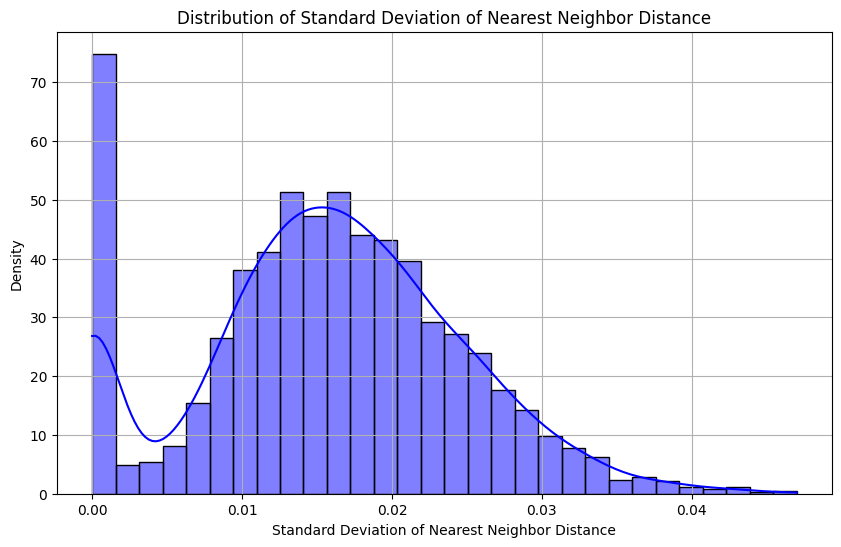

In [74]:
# df_scanpath_feature['std_nn_distance']画个分布图
plt.figure(figsize=(10, 6))
sns.histplot(df_scanpath_feature['std_nn_distance'], bins=30, kde=True, color='blue', stat='density')
plt.title('Distribution of Standard Deviation of Nearest Neighbor Distance')
plt.xlabel('Standard Deviation of Nearest Neighbor Distance')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [75]:
# df_scanpath_feature['std_nn_distance']的分位数
quantiles = df_scanpath_feature['std_nn_distance'].quantile([0.03, 0.5, 0.97])
print("Quantiles of std_nn_distance:")
print(quantiles)


Quantiles of std_nn_distance:
0.03    0.000000
0.50    0.015862
0.97    0.032524
Name: std_nn_distance, dtype: float64


In [41]:
df_scanpath_feature = df_scanpath_feature.fillna(0)

In [76]:
df_scanpath_feature['fixation_count'].describe()

count    3854.000000
mean       13.193565
std        13.622507
min         1.000000
25%         2.000000
50%         8.000000
75%        21.000000
max        81.000000
Name: fixation_count, dtype: float64

In [77]:
# 查看fixation_count为1的比例
fixation_count_1_ratio = (df_scanpath_feature['fixation_count'] == 1).sum() / df_scanpath_feature.shape[0]
print(f"Fixation count of 1 ratio: {fixation_count_1_ratio:.2%}")

Fixation count of 1 ratio: 22.99%


In [78]:
# 保存
file = 'scanpath_features_raw_chx_test_0609.csv'
df_scanpath_feature.to_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput', file), index=False)

In [84]:
# 读取df_scanpath_feature
file = 'scanpath_features_raw_chx_test_0609.csv'
df_scanpath_feature = pd.read_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput', file))
df_scanpath_feature.shape

(3854, 13)

In [85]:
# 根据df_scanpath_feature的ParticipantID	TaskNumber	Task	Section	Condition的IsCorrect，对应cleanDF的ParticipantID	TaskNumber	Task	Section	Condition,查找他们的IsCorrect
# 填充回df_scanpath_feature，而不增长行数
ture_index_list = []

for i, row in df_scanpath_feature.iterrows():
    # 记录进度
    if i % 100 == 0:
        print(f"Processing row {i}/{len(df_scanpath_feature)}")

    participant_id = row['ParticipantID']
    task_number = row['TaskNumber']
    task = row['Task']
    section = row['Section']
    condition = row['Condition']


    try:
        matched_data = cleanDF[
            (cleanDF['ParticipantID'] == participant_id) &
            (cleanDF['TaskNumber'] == task_number) &
            (cleanDF['Task'] == task) &
            (cleanDF['Section'] == section) &
            (cleanDF['Condition'] == condition)
        ].iloc[0]['IsCorrect']
    except IndexError:
        print(f"IndexError for ParticipantID: {participant_id}, TaskNumber: {task_number}, Task: {task}, Section: {section}, Condition: {condition}")
        continue
    

    if matched_data == np.True_:
        df_scanpath_feature.loc[i, 'IsCorrect'] = True
    else:
        df_scanpath_feature.loc[i, 'IsCorrect'] = False
    


Processing row 0/3854
Processing row 100/3854
Processing row 200/3854
Processing row 300/3854
Processing row 400/3854
Processing row 500/3854
Processing row 600/3854
Processing row 700/3854
Processing row 800/3854
Processing row 900/3854
Processing row 1000/3854
Processing row 1100/3854
Processing row 1200/3854
Processing row 1300/3854
Processing row 1400/3854
Processing row 1500/3854
Processing row 1600/3854
Processing row 1700/3854
Processing row 1800/3854
Processing row 1900/3854
Processing row 2000/3854
Processing row 2100/3854
Processing row 2200/3854
Processing row 2300/3854
Processing row 2400/3854
Processing row 2500/3854
Processing row 2600/3854
Processing row 2700/3854
Processing row 2800/3854
Processing row 2900/3854
Processing row 3000/3854
Processing row 3100/3854
Processing row 3200/3854
Processing row 3300/3854
Processing row 3400/3854
Processing row 3500/3854
Processing row 3600/3854
Processing row 3700/3854
Processing row 3800/3854


In [86]:
df_scanpath_feature.shape

(3854, 14)

In [87]:
# 保存
file = 'scanpath_features_chx_IsCorrect_0609.csv'
df_scanpath_feature.to_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput', file), index=False)

In [95]:
# 读取df_scanpath_feature
file = 'scanpath_features_chx_IsCorrect_0609.csv'
df_scanpath_feature = pd.read_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput', file), index_col=False)
df_scanpath_feature.shape

(3854, 14)

In [99]:
# 把fixation_count大于3%分位数的行删除
def remove_outliers(df, column, threshold=0.99):
    # 计算分位数
    q = df[column].quantile(threshold)
    # 剔除大于分位数的值
    df = df[df[column] <= q]
    return df

threshold = 0.97
df_scanpath_feature = remove_outliers(df_scanpath_feature, 'fixation_count', threshold)

# std_nn_distance 大于3%分位数的行删除
df_scanpath_feature = remove_outliers(df_scanpath_feature, 'std_nn_distance', threshold)

# nn_distances = 0的行删除
df_scanpath_feature = df_scanpath_feature[df_scanpath_feature['std_nn_distance'] != 0]


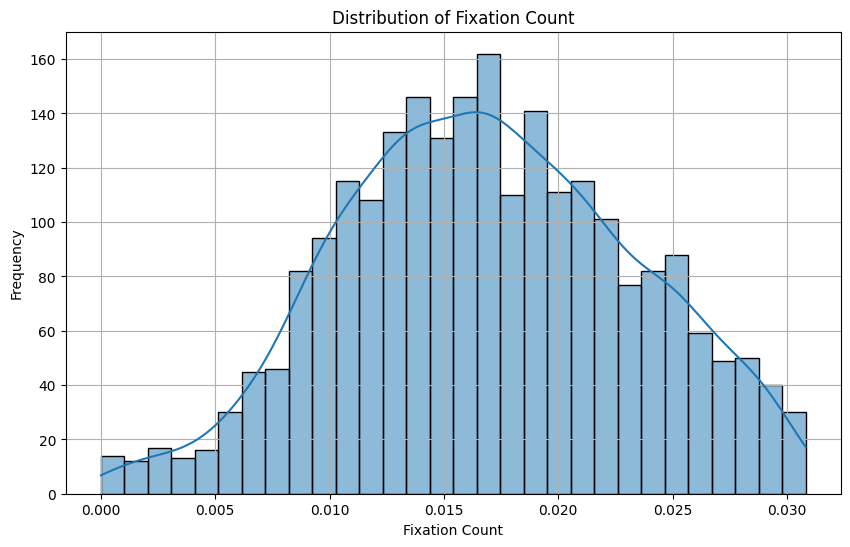

In [100]:
# 画出df_scanpath_feature的fixation_count的分布
plt.figure(figsize=(10, 6))
sns.histplot(df_scanpath_feature['std_nn_distance'], bins=30, kde=True)
plt.title('Distribution of Fixation Count')
plt.xlabel('Fixation Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [101]:
df_scanpath_feature['fixation_count'].describe()

count    2363.000000
mean       17.184934
std        10.551478
min         3.000000
25%         8.000000
50%        15.000000
75%        25.000000
max        43.000000
Name: fixation_count, dtype: float64

In [102]:
# 分析不同condition下fixation_count	average_duration	duration_variance	max_duration	average_amplitude	total_amplitude	last_fixation_duration的均值和方差
def analyze_condition(df, column, groupby='Condition'):
    """
    分析不同condition下的均值和方差
    """
    # 按照Condition分组
    grouped = df.groupby(groupby)[column].agg(['mean', 'var'])
    return grouped

# 分析不同condition下fixation_count	average_duration	duration_variance	max_duration	average_amplitude	total_amplitude	last_fixation_duration的均值和方差
columns = ['fixation_count', 'average_duration', 'duration_variance', 'max_duration', 'average_amplitude', 'total_amplitude', 'last_fixation_duration']
for column in columns:
    print(f'Condition: {column}')
    print(analyze_condition(df_scanpath_feature, column))
    print('\n')



Condition: fixation_count
                mean         var
Condition                       
LG         17.300000   97.144995
TD          4.466667    5.756206
VR         20.018393  105.304894


Condition: average_duration
               mean       var
Condition                    
LG         0.629861  0.097077
TD         2.959952  3.706718
VR         0.552394  0.070749


Condition: duration_variance
                mean         var
Condition                       
LG          0.966985    3.020459
TD         11.140102  246.856166
VR          0.805351    1.681246


Condition: max_duration
               mean        var
Condition                     
LG         2.965468   4.531832
TD         6.633684  19.315965
VR         2.937565   4.008327


Condition: average_amplitude
               mean       var
Condition                    
LG         1.096034  0.023271
TD         1.097184  0.028725
VR         1.053547  0.011798


Condition: total_amplitude
                mean         var
Condition

In [103]:
# df_scanpath_feature fixation_count == 1的个数
df_scanpath_feature[df_scanpath_feature['fixation_count'] == 1].shape[0]

0

In [104]:
df_scanpath_feature.shape[0]

2363

Boxplot of fixation_count by Condition


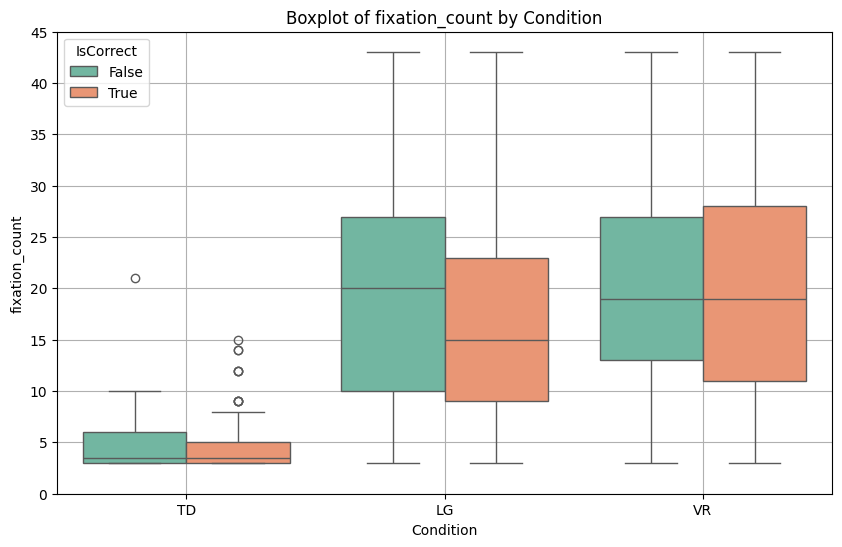

Boxplot of average_duration by Condition


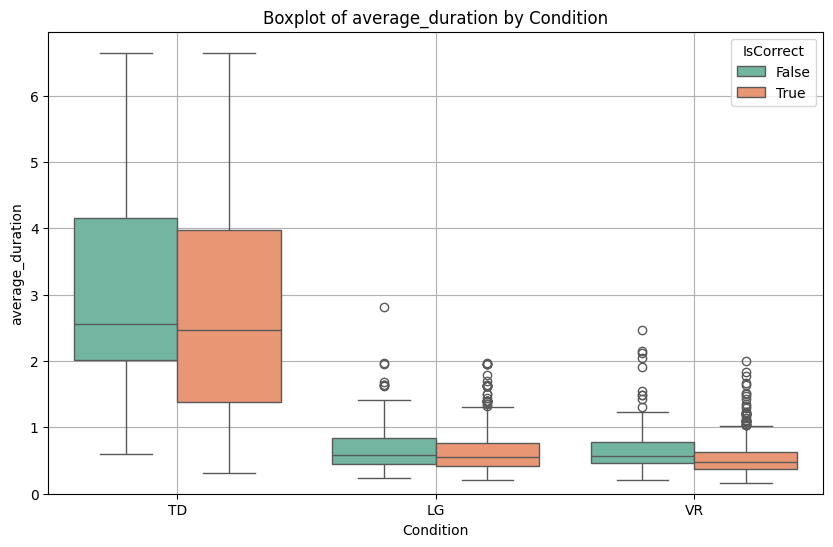

Boxplot of duration_variance by Condition


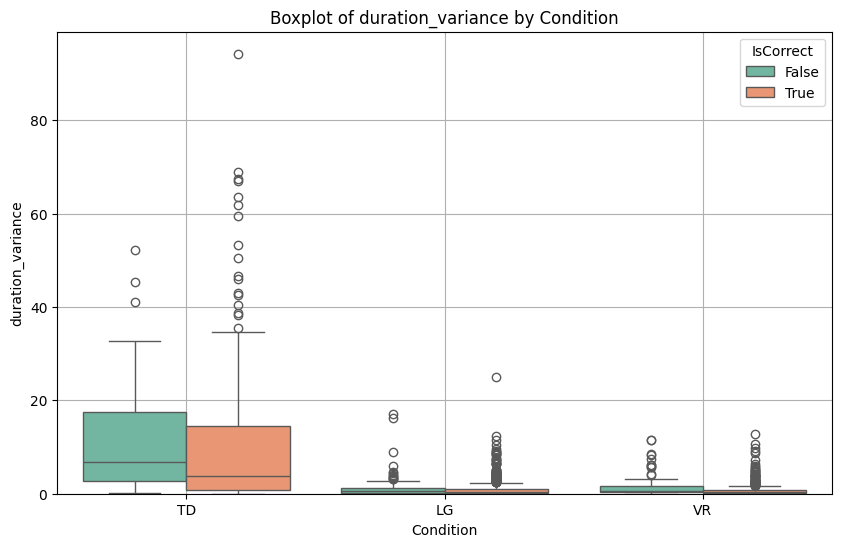

Boxplot of max_duration by Condition


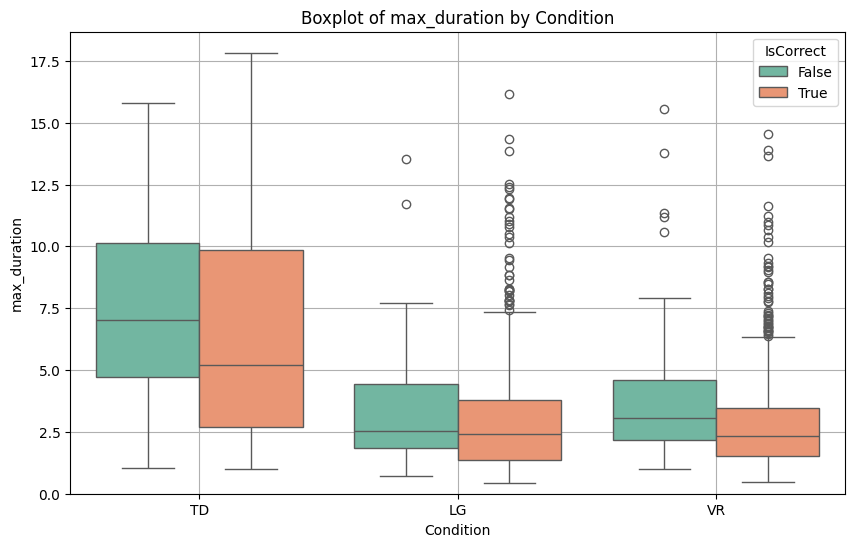

Boxplot of average_amplitude by Condition


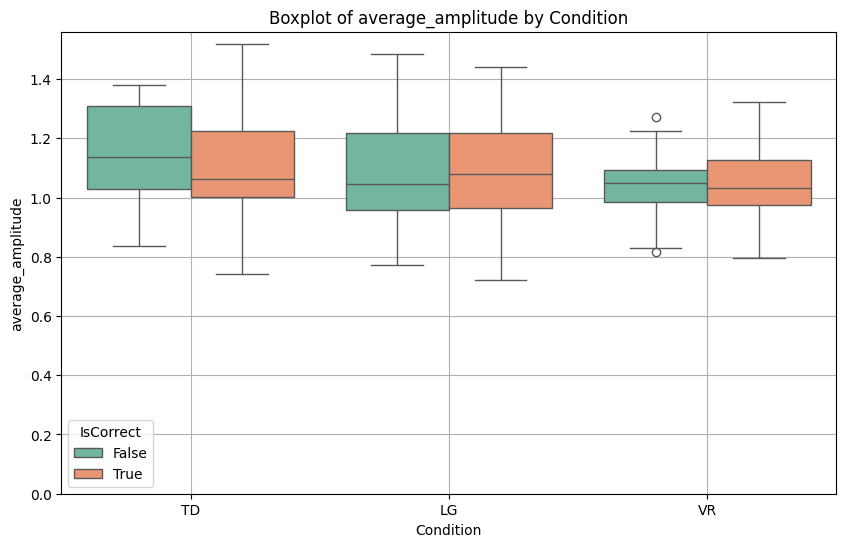

Boxplot of total_amplitude by Condition


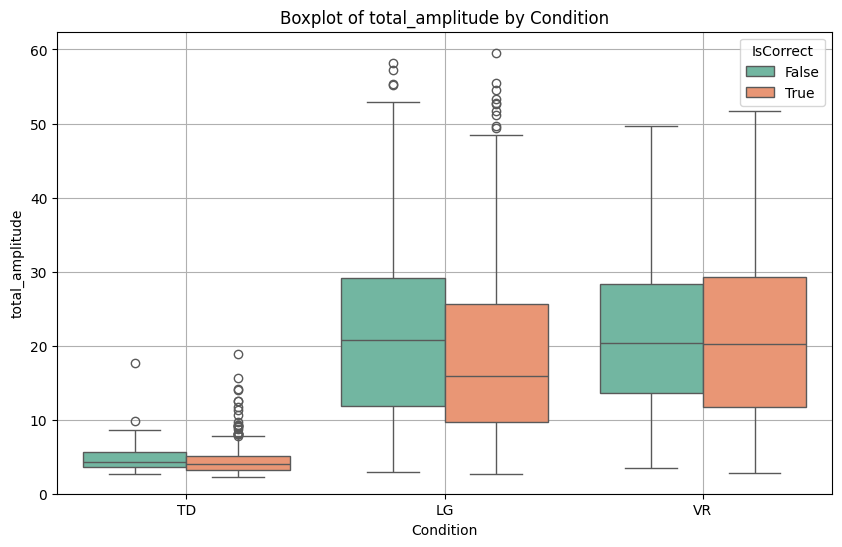

Boxplot of last_fixation_duration by Condition


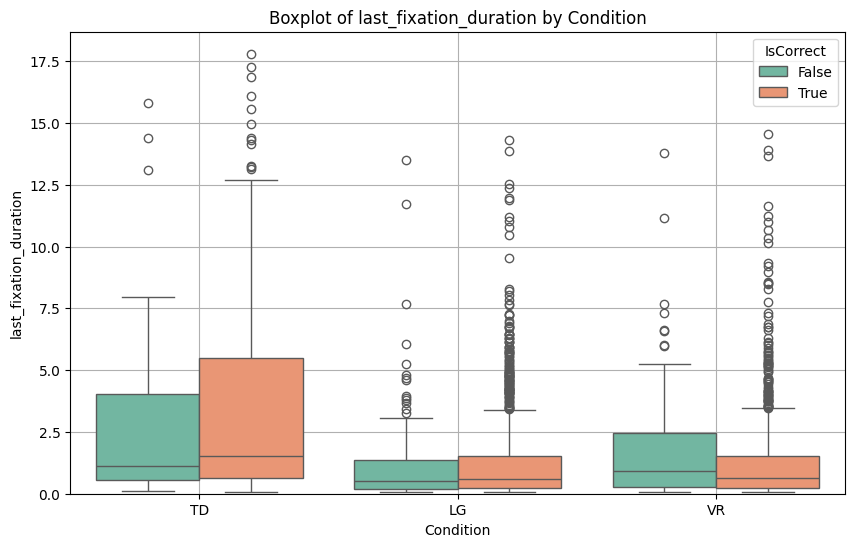

In [105]:
# 画出不同condition下fixation_count	average_duration	duration_variance	max_duration	average_amplitude	total_amplitude	last_fixation_duration的箱线图
# 三个箱线图颜色不一样

def plot_boxplot(df, column):
    """
    绘制不同condition下的箱线图
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Condition', y=column, hue='IsCorrect', data=df, palette='Set2')
    plt.title(f'Boxplot of {column} by Condition')
    plt.xlabel('Condition')
    # 设置y轴范围
    plt.ylim(0,)
    plt.ylabel(column)
    plt.grid()
    plt.show()

# 画出不同condition下fixation_count	average_duration	duration_variance	max_duration	average_amplitude	total_amplitude	last_fixation_duration的箱线图
# 按照td,lg,vr的顺序
df_scanpath_feature['Condition'] = pd.Categorical(df_scanpath_feature['Condition'], categories=['TD', 'LG', 'VR'], ordered=True)
columns = ['fixation_count', 'average_duration', 'duration_variance', 'max_duration', 'average_amplitude', 'total_amplitude', 'last_fixation_duration']
for column in columns:
    print(f'Boxplot of {column} by Condition')
    plot_boxplot(df_scanpath_feature, column)
    


In [503]:
# 分析不同IsCorrect下fixation_count	average_duration	duration_variance	max_duration	average_amplitude	total_amplitude	last_fixation_duration的均值和方差
analyze_condition(df_scanpath_feature, 'fixation_count', groupby='IsCorrect')
for column in columns:
    print(f'Condition: {column}')
    print(analyze_condition(df_scanpath_feature, column, groupby='IsCorrect'))
    print('\n')

Condition: fixation_count
                mean         var
IsCorrect                       
False      19.277946  130.958876
True       17.268396  120.909053


Condition: average_duration
               mean       var
IsCorrect                    
False      0.898879  0.897457
True       0.814067  0.948752


Condition: duration_variance
               mean        var
IsCorrect                     
False      2.270057  32.991668
True       1.848665  36.490330


Condition: max_duration
               mean       var
IsCorrect                    
False      3.813286  6.919954
True       3.234696  6.917184


Condition: average_amplitude
               mean       var
IsCorrect                    
False      1.072735  0.019962
True       1.078836  0.019133


Condition: total_amplitude
                mean         var
IsCorrect                       
False      20.574962  163.821502
True       18.491892  142.543419


Condition: last_fixation_duration
               mean       var
IsCorrect    

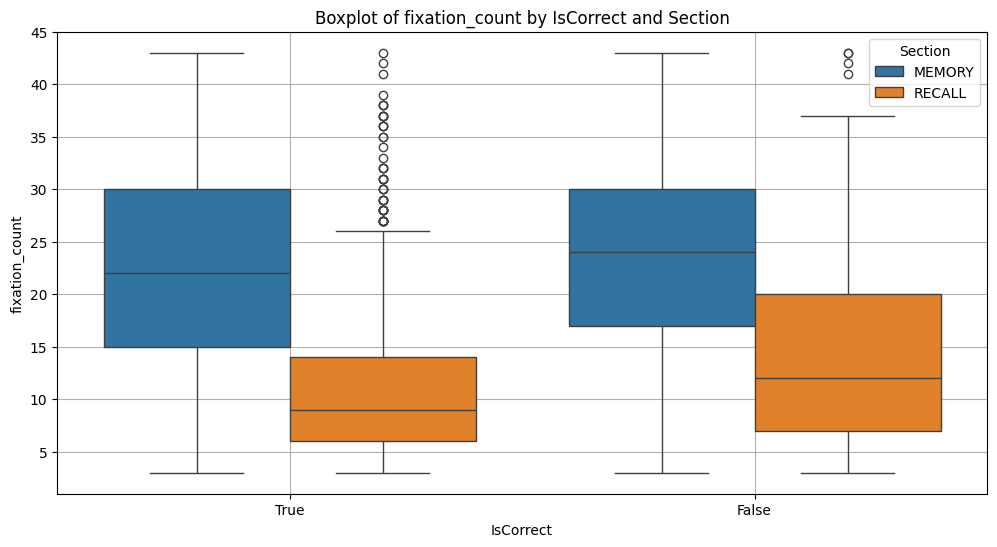

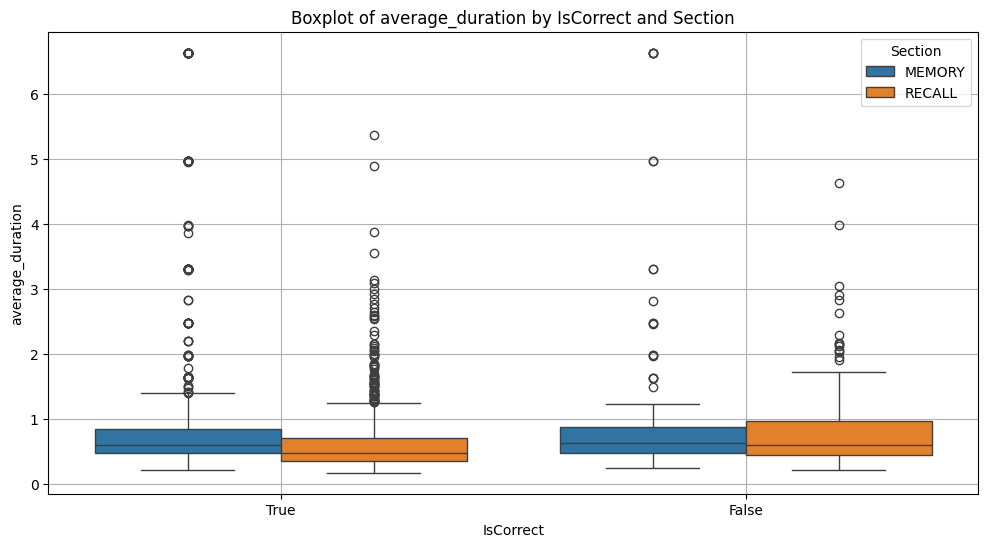

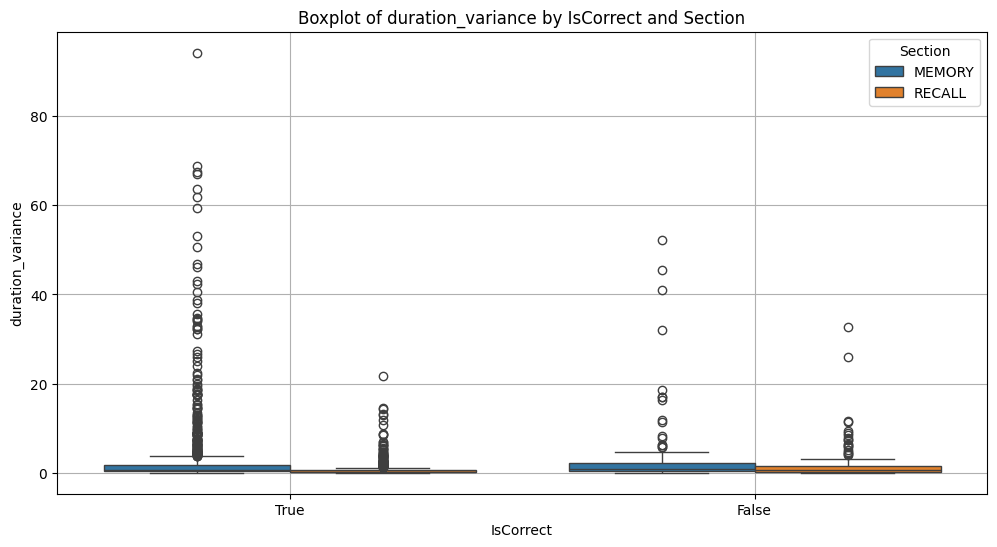

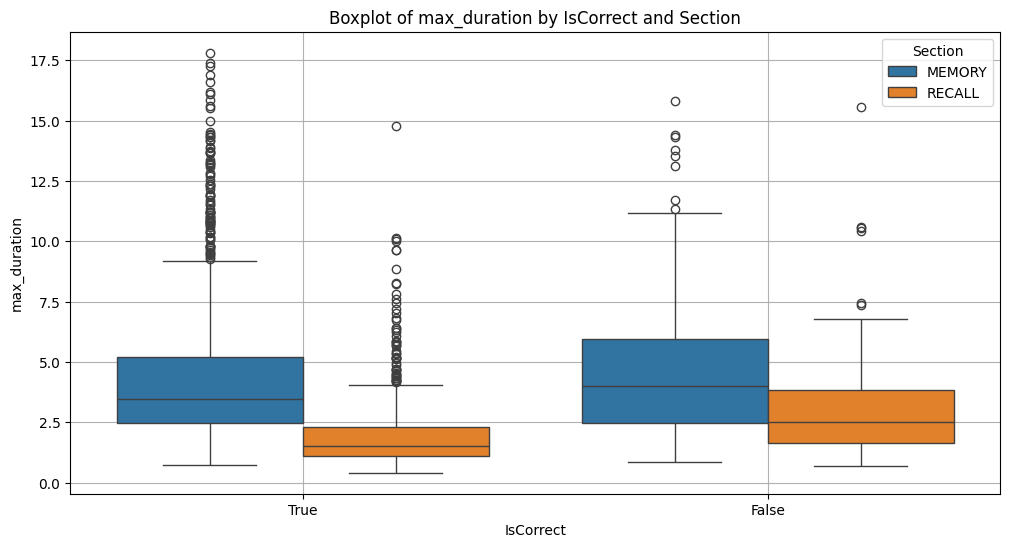

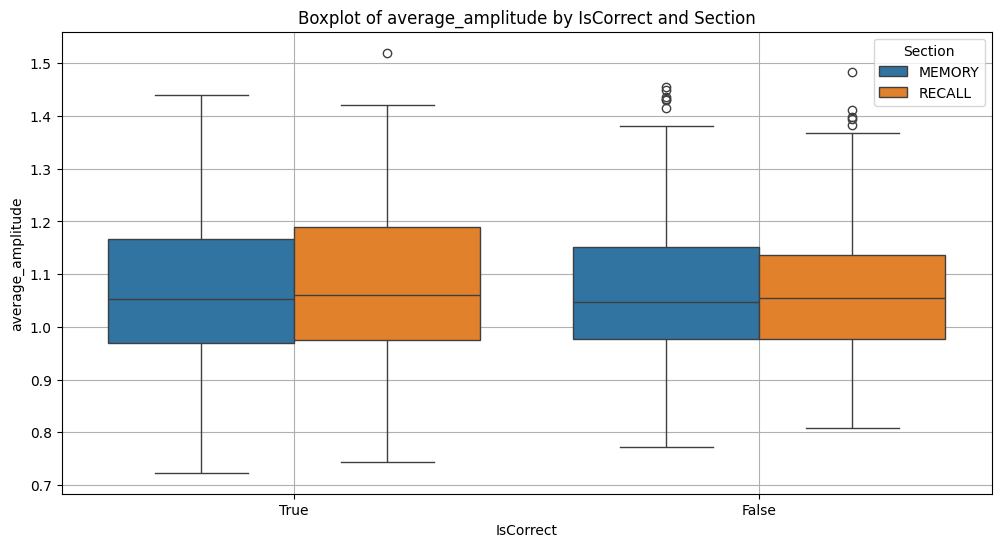

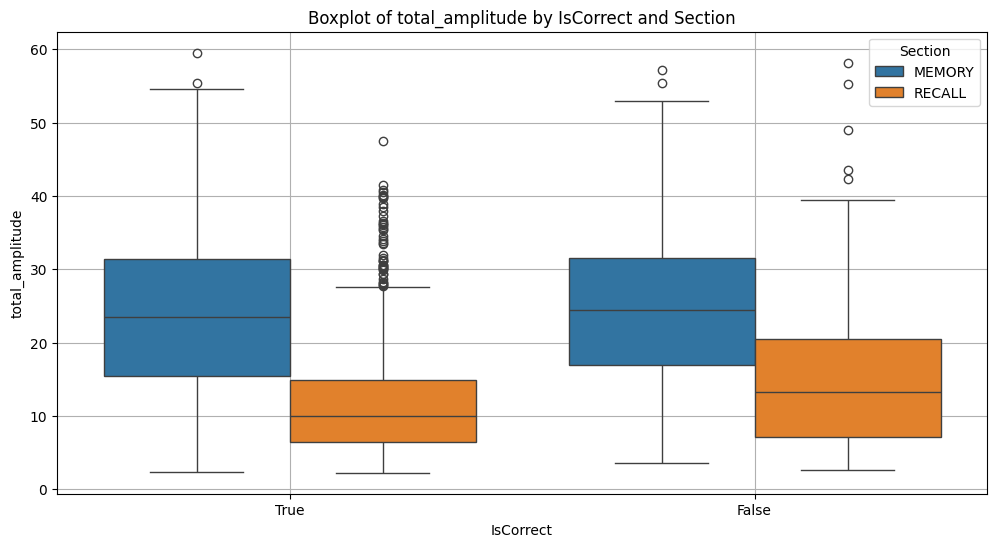

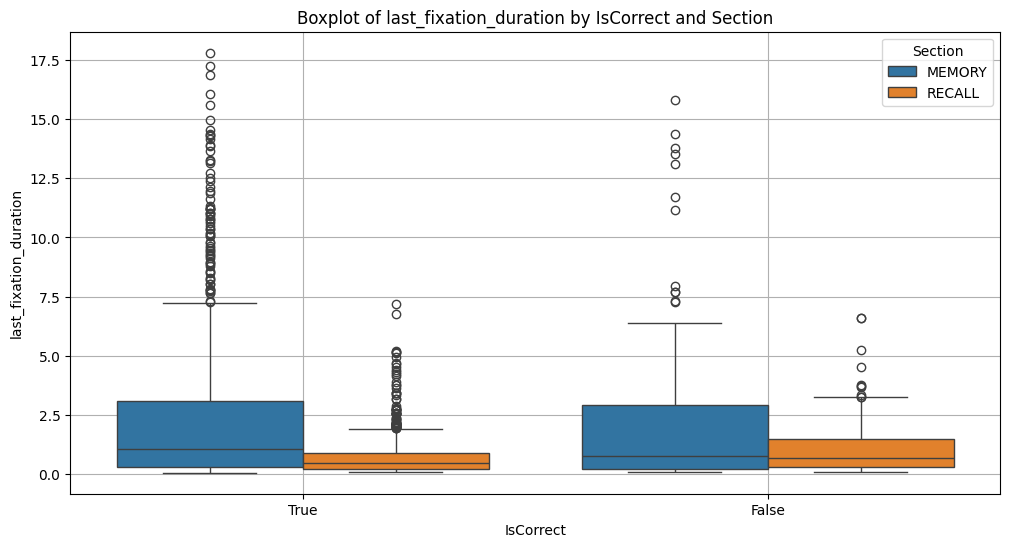

In [106]:
# 不仅参考iscorrect的True还是False, 还参考Section是MEMORY还是RECALL,绘图
def plot_boxplot_IsCorrect_Section(df, column):
    """
    绘制不同IsCorrect和Section下的箱线图
    先画memory,再画recall
    """
    # 先画memory,再画recall
    df['Section'] = pd.Categorical(df['Section'], categories=['MEMORY', 'RECALL'], ordered=True)
    df['IsCorrect'] = pd.Categorical(df['IsCorrect'], categories=[True, False], ordered=True)
    # 画箱线图
    df = df.sort_values(by=['Section', 'IsCorrect'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='IsCorrect', y=column, hue='Section', data=df)
    plt.title(f'Boxplot of {column} by IsCorrect and Section')
    plt.xlabel('IsCorrect')
    plt.ylabel(column)
    plt.grid()
    plt.show()

columns = ['fixation_count', 'average_duration', 'duration_variance', 'max_duration', 'average_amplitude', 'total_amplitude', 'last_fixation_duration']
for column in columns:
    plot_boxplot_IsCorrect_Section(df_scanpath_feature, column)


In [397]:
# 读取E:\Project1_\LG\ConsolidatedOutput\S1FeatureExtracted.csv
df_s1_feature = pd.read_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput','S1FeatureExtracted.csv'))


In [ ]:
# df_s1_feature根据ParticipantID	TaskNumber	Condition	Task	Section分组，然后在clean_df中找is_correct列，填充回去

# 在Task后加入一列IsCorrect，空列
df_s1_feature.insert(df_s1_feature.columns.get_loc('Section') + 1, 'IsCorrect', np.nan)

# 遍历df_s1_feature的每一行，根据ParticipantID	TaskNumber	Condition	Task	Section在clean_df中找IsCorrect列，填充回去
for i, row in df_s1_feature.iterrows():
    # 记录进度
    if i % 100 == 0:
        print(f"Processing row {i}/{len(df_s1_feature)}")

    participant_id = row['ParticipantID']
    task_number = row['TaskNumber']
    condition = row['Condition']
    task = row['Task']
    section = row['Section']

    try:
        matched_data = cleanDF[
            (cleanDF['ParticipantID'] == participant_id) &
            (cleanDF['TaskNumber'] == task_number) &
            (cleanDF['Condition'] == condition) &
            (cleanDF['Task'] == task) &
            (cleanDF['Section'] == section)
        ].iloc[0]['IsCorrect']
    except IndexError:
        print(f"IndexError for ParticipantID: {participant_id}, TaskNumber: {task_number}, Condition: {condition}, Task: {task}, Section: {section}")
        # 填充为True
        df_s1_feature.loc[i, 'IsCorrect'] = True
        continue
    
    df_s1_feature.loc[i, 'IsCorrect'] = matched_data


Processing row 0/276


C:\Users\Chen_Hex\AppData\Local\Temp\ipykernel_14448\902768615.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_s1_feature.loc[i, 'IsCorrect'] = matched_data


IndexError for ParticipantID: 3, TaskNumber: 0, Condition: TD, Task: T1, Section: MEMORY
IndexError for ParticipantID: 3, TaskNumber: 0, Condition: TD, Task: T1, Section: RECALL
Processing row 100/276
Processing row 200/276


In [400]:
# 保存E:\Project1_\LG\ConsolidatedOutput\S1FeatureExtracted_chx.csv
df_s1_feature.to_csv(os.path.join(r'E:\Project1_\LG\ConsolidatedOutput','S1FeatureExtracted_chx.csv'), index=False)